In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import SimpleRNN, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import RMSprop
import os

In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

## Instruções:

Copie o arquivo wonderland.txt para o google colab. Clique com o botão direito do mouse no arquivo e depois clique em **Copiar caminho**. Cole o caminho copiado na variável INPUT_FILE abaixo

## Carregando e processando os dados

In [12]:
INPUT_FILE = "/content/wonderland.txt"

In [13]:
# Extract text from input
print("Extracting text from input...")
fin = open(INPUT_FILE, 'rb')
lines = []
for line in fin:
    line = line.strip().lower()
    line = line.decode("ascii", "ignore")
    if len(line) == 0:
        continue
    lines.append(line)
fin.close()
text = " ".join(lines)

Extracting text from input...


In [14]:
text

'project gutenbergs alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org title: alices adventures in wonderland author: lewis carroll posting date: june 25, 2008 [ebook #11] release date: march, 1994 last updated: october 6, 2016 language: english character set encoding: utf-8 *** start of this project gutenberg ebook alices adventures in wonderland *** alices adventures in wonderland lewis carroll the millennium fulcrum edition 3.0 chapter i. down the rabbit-hole alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, and what is the use of a book, thought alice without pictures or c

Agora, estamos construindo um RNN em nível de caracteres. Nesse caso, o vocabulário é o conjunto de caracteres que ocorrem no texto.

Estaremos lidando com os índices desses caracteres, e não com os próprios caracteres. O trecho de código a seguir cria este mapeamento de caracter para numérico:

In [15]:
#Mapeamento
chars = sorted(list(set(text)))
nb_chars = len(chars)
char2index = dict((c, i) for i, c in enumerate(chars))
index2char = dict((i, c) for i, c in enumerate(chars))

In [16]:
index2char

{0: ' ',
 1: '!',
 2: '#',
 3: '$',
 4: '%',
 5: '(',
 6: ')',
 7: '*',
 8: ',',
 9: '-',
 10: '.',
 11: '/',
 12: '0',
 13: '1',
 14: '2',
 15: '3',
 16: '4',
 17: '5',
 18: '6',
 19: '7',
 20: '8',
 21: '9',
 22: ':',
 23: ';',
 24: '?',
 25: '@',
 26: '[',
 27: ']',
 28: '_',
 29: 'a',
 30: 'b',
 31: 'c',
 32: 'd',
 33: 'e',
 34: 'f',
 35: 'g',
 36: 'h',
 37: 'i',
 38: 'j',
 39: 'k',
 40: 'l',
 41: 'm',
 42: 'n',
 43: 'o',
 44: 'p',
 45: 'q',
 46: 'r',
 47: 's',
 48: 't',
 49: 'u',
 50: 'v',
 51: 'w',
 52: 'x',
 53: 'y',
 54: 'z'}

Na próxima etapa, criamos os textos de entrada e os labels.

In [17]:
text

'project gutenbergs alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever.  you may copy it, give it away or re-use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org title: alices adventures in wonderland author: lewis carroll posting date: june 25, 2008 [ebook #11] release date: march, 1994 last updated: october 6, 2016 language: english character set encoding: utf-8 *** start of this project gutenberg ebook alices adventures in wonderland *** alices adventures in wonderland lewis carroll the millennium fulcrum edition 3.0 chapter i. down the rabbit-hole alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, and what is the use of a book, thought alice without pictures or c

In [18]:
# criando entradas e rótulos a partir do texto. Fazemos isso
# Por exemplo:
# assumindo um texto de entrada "O céu estava caindo", obteríamos o
# sequência seguinte de input_chars e label_chars (somente os 5 primeiros):

#   The sky wa -> s
#   he sky was ->
#   e sky was  -> f
#    sky was f -> a
#   sky was fa -> l

#Criando inputs e labels
print("Criando inputs e labels...")
SEQLEN = 10
STEP = 1
input_chars = []
label_chars = []
for i in range(0, len(text) - SEQLEN, STEP):
    input_chars.append(text[i:i + SEQLEN])
    label_chars.append(text[i + SEQLEN])

Criando inputs e labels...


In [19]:
input_chars[0:5]

['project gu', 'roject gut', 'oject gute', 'ject guten', 'ect gutenb']

In [20]:
label_chars[0:5]

['t', 'e', 'n', 'b', 'e']

A próxima etapa é vetorizar esses textos de entrada e rótulos.

In [21]:
#Vetorizando inputs e labels
print("Vectorizing inputs and labels...")
X = np.zeros((len(input_chars), SEQLEN, nb_chars), dtype=np.bool_)
y = np.zeros((len(input_chars), nb_chars), dtype=np.bool_)
for i, input_char in enumerate(input_chars):
    for j, ch in enumerate(input_char):
        X[i, j, char2index[ch]] = 1
    y[i, char2index[label_chars[i]]] = 1

Vectorizing inputs and labels...


In [22]:
X[0].shape

(10, 55)

In [23]:
y[0].shape

(55,)

In [24]:
def generate_predictions(model, test_chars, char2index, index2char, num_preds):
    confidences = []
    for i in range(num_preds):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        pred = model.predict(Xtest, verbose=0)[0]
        confidences.append(np.max(pred))
        ypred = index2char[np.argmax(pred)]
        test_chars = test_chars[1:] + ypred
    return confidences

## Agora é a sua vez!

Construa uma camada RNN (SimpleRNN) conectada a uma camada densa (Dense) (ou totalmente conectada). A camada densa deve possuir (nb_char) neurônios, que vão aprender a gerar scores para cada um dos caracteres do vocabulário.

A ativação na camada densa é um softmax, que normaliza os scores em probabilidades. O character com maior probabilidade é escolhido como a previsão da rede neural.

Compile o modelo com a função de custo de entropia cruzada categórica, uma boa função de custo para saídas categóricas e o otimizador RMSprop.

In [25]:
# Model parameters
HIDDEN_SIZE = 256
BATCH_SIZE = 128
NUM_ITERATIONS = 50
NUM_EPOCHS_PER_ITERATION = 1
NUM_PREDS_PER_EPOCH = 100
optimizer = RMSprop(learning_rate=0.0001)

#Define modelo
model = Sequential()
model.add(SimpleRNN(HIDDEN_SIZE, return_sequences=False, input_shape=(SEQLEN, nb_chars), unroll=True))
model.add(Dropout(0.3))  #Mexer no Dropout
model.add(Dense(nb_chars))
model.add(BatchNormalization())
model.add(Activation("softmax"))
#model.add(LSTM(64))
optimizer = RMSprop(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)

In [26]:
losses = []
all_confidences = []

Vamos treinar o nosso modelo para que ele seja capaz de gerar um caracter a partir de uma entrada arbitrária, em seguida, eliminar o primeiro caracter da entrada e anexar o caracter previsto de nossa execução anterior e gerar outro caracter e assim por diante.

Fasremos isso 100 vezes (NUM_PREDS_PER_EPOCH=100) e vamos gerar a string resultante.

Iteration #: 0
Generating characters from the prompt:  to learn 
 to learn the sat out out out out out out out out out out out out out out out out out out out out out out out 
Iteration #: 1
Generating characters from the prompt: with all t
with all the said the said the said the said the said the said the said the said the said the said the said th
Iteration #: 2
Generating characters from the prompt: s twelve, 
s twelve, and the gat in the gat in the gat in the gat in the gat in the gat in the gat in the gat in the gat 
Iteration #: 3
Generating characters from the prompt: roject gut
roject guten the the the the the the the the the the the the the the the the the the the the the the the the t
Iteration #: 4
Generating characters from the prompt: to ear. pl
to ear. plice said the sald alice said the sald alice said the sald alice said the sald alice said the sald al
Iteration #: 5
Generating characters from the prompt: pes: this 
pes: this ing ous and the she sout and the she sout and

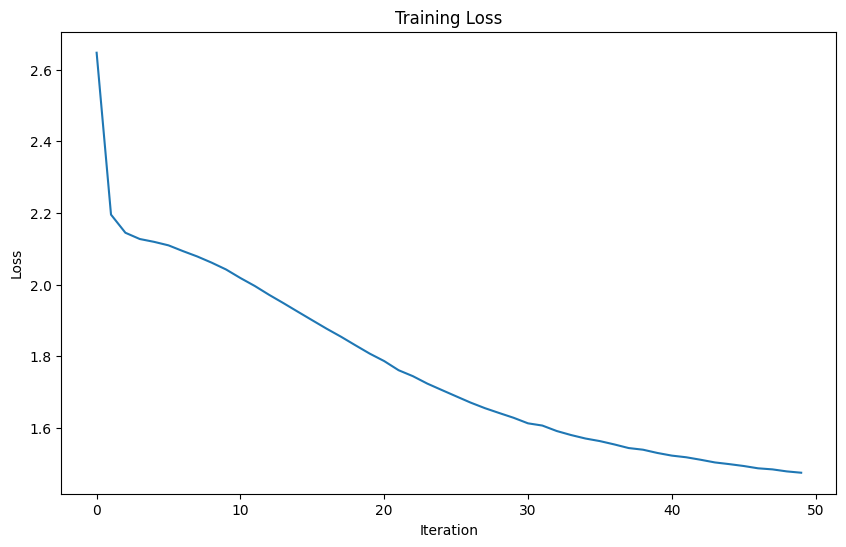

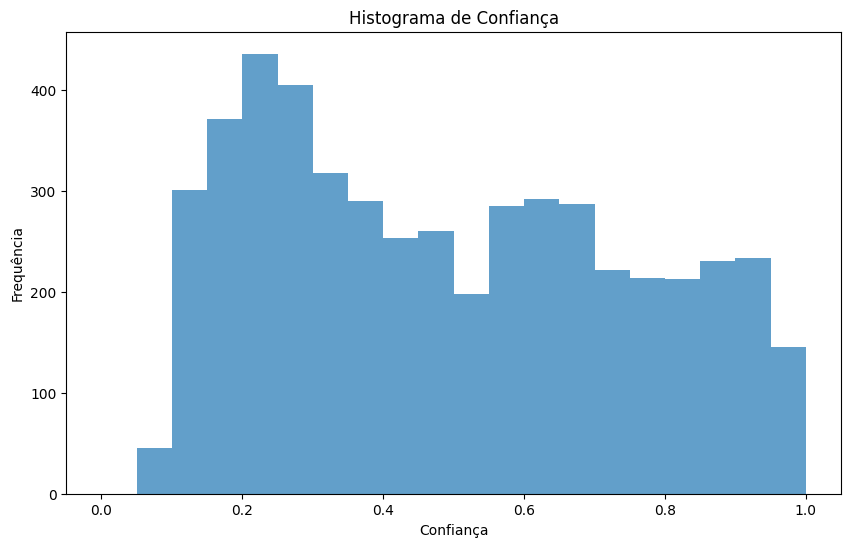

In [27]:
# Treinando o modelo
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print("Iteration #: %d" % (iteration))
    history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION, verbose=0)
    losses.extend(history.history['loss'])

    # Testando o modelo e calculando confianças
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]
    print("Generating characters from the prompt: %s" % (test_chars))
    print(test_chars, end="")

    confidences = []
    for _ in range(NUM_PREDS_PER_EPOCH):
        Xtest = np.zeros((1, SEQLEN, nb_chars))
        for i, ch in enumerate(test_chars):
            Xtest[0, i, char2index[ch]] = 1
        pred = model.predict(Xtest, verbose=0)[0]
        confidences.append(np.max(pred))
        ypred = index2char[np.argmax(pred)]
        print(ypred, end="")
        test_chars = test_chars[1:] + ypred

    all_confidences.extend(confidences)
    print()

# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

# Plot histograma de confiança
plt.figure(figsize=(10, 6))
plt.hist(all_confidences, bins=20, range=(0, 1), alpha=0.7)
plt.title('Histograma de Confiança')
plt.xlabel('Confiança')
plt.ylabel('Frequência')
plt.show()

## 1 - O que falta para este modelo ficar bom? Utilize os conhecimentos vistos em sala de aula para alterar os parâmetros do modelo a conseguir uma melhor assertividade.

## 2- Bônus: Altere os dados utilizados (é só trocar o arquivo /content/wonderland.txt por outro txt ) para algum de sua preferência e rode o modelo com ele e discuta os resultados.

In [28]:
#Eu adicionei algumas camadas a mais como o dense e o batch normalization, adicionei funcoes para os graficos e mexi nos parametros para melhorar o modelo
#No bonus eu apliquei o mesmo codigo no livro pequeno principe e o resultado foi similar ao do alice, claro eu poderia otimizar com o LSTM mas tive problema
#Com os resultados e ja que estamos ainda estudando mais sobre ele decidi usar o que foi passado ate agora